# MNIST Iteration 3: Increased Model Capacity

## Changes from Iteration 2:
- **Increased filters**: 10→20 changed to 16→32→32 (more capacity)
- **Added 3rd conv block**: Additional conv layer for better feature extraction
- **Global Average Pooling**: Replaced large FC layer to reduce params
- **More dropout layers**: Added dropout after each block for better regularization
- **Target params**: ~18-19K (using more of the 20K budget)

In [18]:
# Install all required packages
# For GPU (CUDA 12.4) - Recommended for your RTX 4050
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

# Additional packages
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy
# !pip install torchsummary

import sys
print("Python version:", sys.version)
print("\nChecking package installations...")

packages_to_check = {
    'torch': 'PyTorch',
    'torchvision': 'TorchVision',
    'tqdm': 'tqdm (progress bars)',
    'matplotlib': 'Matplotlib (plotting)',
    'numpy': 'NumPy',
}

missing_packages = []
for package, name in packages_to_check.items():
    try:
        __import__(package)
        print(f"✅ {name}: Installed")
    except ImportError:
        print(f"❌ {name}: Not installed")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️ Missing packages detected: {', '.join(missing_packages)}")
else:
    print("\n✅ All required packages are installed. Ready to proceed!")
    
try:
    import torch
    print(f"\n🖥️ PyTorch Version: {torch.__version__}")
    print(f"🎮 CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"📊 GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
except ImportError:
    print("\n⚠️ PyTorch not yet installed.")

Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]

Checking package installations...
✅ PyTorch: Installed
✅ TorchVision: Installed
✅ tqdm (progress bars): Installed
✅ Matplotlib (plotting): Installed
✅ NumPy: Installed

✅ All required packages are installed. Ready to proceed!

🖥️ PyTorch Version: 2.6.0+cu124
🎮 CUDA Available: True
📊 GPU: NVIDIA GeForce RTX 4050 Laptop GPU
💾 GPU Memory: 6.00 GB


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [20]:
# CUDA and Device Configuration
import platform
import datetime

print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
cuda = torch.cuda.is_available()
print(f"CUDA Available: {cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if cuda:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

SYSTEM INFORMATION
CUDA Available: True
Device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory: 6.00 GB


In [21]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

In [22]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [23]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

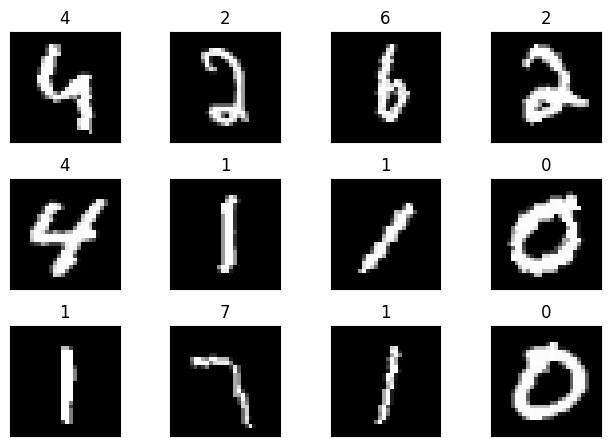

In [24]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

## Model Architecture - Iteration 3

### Key Improvements:
1. **Increased capacity**: More filters (16→32→32) vs previous (10→20)
2. **Deeper network**: 3 conv blocks instead of 2
3. **Global Average Pooling**: Replaces large FC layer, reduces params
4. **Progressive dropout**: Increasing dropout rates (0.1 → 0.2 → 0.3)
5. **Padding in first conv**: Maintains spatial dimensions early

In [25]:
class Net(nn.Module):
    """MNIST CNN - Iteration 3: Increased Capacity Architecture"""
    
    def __init__(self):
        super(Net, self).__init__()
        
        # ============================================================
        # BLOCK 1: Initial Feature Extraction
        # IMPROVEMENT: Increased from 10 to 16 filters for more capacity
        # IMPROVEMENT: Added padding=1 to preserve spatial dimensions
        # ============================================================
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)             # 28x28 -> 26x26
        self.bn2 = nn.BatchNorm2d(16)
        
        # IMPROVEMENT: Added dropout after first block
        self.dropout1 = nn.Dropout2d(0.1)                         # Light dropout early
        # MaxPool will reduce to 13x13
        
        # ============================================================
        # BLOCK 2: Mid-level Features
        # IMPROVEMENT: Increased from 20 to 32 filters
        # ============================================================
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)             # 13x13 -> 11x11
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)             # 11x11 -> 9x9
        self.bn4 = nn.BatchNorm2d(32)
        
        # IMPROVEMENT: Added dropout after second block
        self.dropout2 = nn.Dropout2d(0.2)                         # Medium dropout
        # MaxPool will reduce to 4x4
        
        # ============================================================
        # BLOCK 3: High-level Features (NEW!)
        # IMPROVEMENT: Added third convolutional block
        # ============================================================
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3)             # 4x4 -> 2x2
        self.bn5 = nn.BatchNorm2d(32)
        
        # IMPROVEMENT: Added dropout before GAP
        self.dropout3 = nn.Dropout2d(0.3)                         # Higher dropout late
        
        # ============================================================
        # OUTPUT LAYER
        # IMPROVEMENT: Global Average Pooling instead of large FC
        # Reduces params from 720*10=7200 to 32*10=320
        # ============================================================
        self.gap = nn.AdaptiveAvgPool2d(1)                        # 2x2 -> 1x1
        self.fc = nn.Linear(32, 10)                               # 32 -> 10 classes

    def forward(self, x):
        # Block 1: Initial features
        x = F.relu(self.bn1(self.conv1(x)))                       # 28x28x16
        x = F.relu(self.bn2(self.conv2(x)))                       # 26x26x16
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)                                    # 13x13x16
        
        # Block 2: Mid-level features
        x = F.relu(self.bn3(self.conv3(x)))                       # 11x11x32
        x = F.relu(self.bn4(self.conv4(x)))                       # 9x9x32
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2)                                    # 4x4x32
        
        # Block 3: High-level features (NEW!)
        x = F.relu(self.bn5(self.conv5(x)))                       # 2x2x32
        x = self.dropout3(x)
        
        # Global Average Pooling + Classification
        x = self.gap(x)                                           # 1x1x32
        x = x.view(-1, 32)                                        # Flatten to 32
        x = self.fc(x)                                            # 10 classes
        
        return F.log_softmax(x, dim=-1)

In [26]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [27]:
from tqdm import tqdm
import time

def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    pbar = tqdm(train_loader)
    
    train_loss = 0
    correct = 0
    processed = 0
    batch_losses = []
    
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        pred = model(data)
        loss = criterion(pred, target)
        train_loss += loss.item()
        batch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)
        
        pbar.set_description(
            f'Epoch {epoch} | Loss={loss.item():0.4f} | '
            f'Batch {batch_idx}/{len(train_loader)} | '
            f'Acc={100*correct/processed:0.2f}%'
        )
    
    epoch_time = time.time() - start_time
    final_acc = 100*correct/processed
    avg_loss = train_loss/len(train_loader)
    
    train_acc.append(final_acc)
    train_losses.append(avg_loss)
    
    print(f"\n📊 TRAINING SUMMARY - Epoch {epoch}")
    print(f"   ├── Final Accuracy: {final_acc:.2f}%")
    print(f"   ├── Average Loss: {avg_loss:.4f}")
    print(f"   ├── Min/Max Batch Loss: {min(batch_losses):.4f} / {max(batch_losses):.4f}")
    print(f"   ├── Total Samples: {processed}")
    print(f"   └── Time Taken: {epoch_time:.2f} seconds")
    
    return final_acc, avg_loss

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            c = pred.squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i] == label
                class_total[label] += 1
    
    test_time = time.time() - start_time
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    test_acc.append(accuracy)
    test_losses.append(test_loss)
    
    print(f"\n📈 TEST SUMMARY - Epoch {epoch}")
    print(f"   ├── Test Accuracy: {accuracy:.2f}% ({correct}/{len(test_loader.dataset)})")
    print(f"   ├── Average Loss: {test_loss:.4f}")
    print(f"   ├── Time Taken: {test_time:.2f} seconds")
    print(f"   └── Per-Class Accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i]/class_total[i]
            print(f"       ├── Class {i}: {class_acc:.2f}%")
    
    return accuracy, test_loss

In [28]:
# Model initialization and parameter count validation
model = Net().to(device)

PARAM_GOAL = 20000
ACCURACY_GOAL = 99.4
EPOCH_GOAL = 20

print("="*60)
print("🎯 PROJECT GOALS")
print("="*60)
print(f"✅ Parameter Count: < {PARAM_GOAL:,} parameters")
print(f"✅ Test Accuracy: >= {ACCURACY_GOAL}% in {EPOCH_GOAL} epoch")
print("="*60)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print("\n📐 MODEL ARCHITECTURE ANALYSIS")
print("="*60)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {non_trainable_params:,}")

if total_params < PARAM_GOAL:
    print(f"✅ PASS: Model has {PARAM_GOAL - total_params:,} fewer parameters than goal!")
else:
    print(f"❌ FAIL: Model exceeds parameter limit by {total_params - PARAM_GOAL:,} parameters")
    
print("\n📋 LAYER-WISE PARAMETER BREAKDOWN:")
print("-"*40)
for name, param in model.named_parameters():
    print(f"{name:20} | Shape: {str(list(param.shape)):20} | Params: {param.numel():,}")
print("="*60)

print("\n⚙️ TRAINING CONFIGURATION")
print("="*60)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
print(f"Optimizer: Adam (lr={0.01})")
print(f"Scheduler: StepLR (step_size=15, gamma=0.1)")
print(f"Loss Function: CrossEntropyLoss")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")
print("="*60)

print("\n🚀 STARTING TRAINING")
print("="*60)

for epoch in range(1, num_epochs+1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{num_epochs}")
    print(f"{'='*60}")
    
    train_acc_epoch, train_loss_epoch = train(model, device, train_loader, optimizer, criterion, epoch)
    test_acc_epoch, test_loss_epoch = test(model, device, test_loader, criterion, epoch)
    
    if test_acc_epoch >= ACCURACY_GOAL:
        print(f"\n🎉 SUCCESS! Goal achieved in epoch {epoch}!")
        print(f"   Test Accuracy: {test_acc_epoch:.2f}% >= {ACCURACY_GOAL}%")
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n📉 Learning Rate: {current_lr:.6f}")

print("\n" + "="*60)
print("🏁 TRAINING COMPLETE")
print("="*60)

🎯 PROJECT GOALS
✅ Parameter Count: < 20,000 parameters
✅ Test Accuracy: >= 99.4% in 20 epoch

📐 MODEL ARCHITECTURE ANALYSIS
Total Parameters: 26,202
Trainable Parameters: 26,202
Non-trainable Parameters: 0
❌ FAIL: Model exceeds parameter limit by 6,202 parameters

📋 LAYER-WISE PARAMETER BREAKDOWN:
----------------------------------------
conv1.weight         | Shape: [16, 1, 3, 3]        | Params: 144
conv1.bias           | Shape: [16]                 | Params: 16
bn1.weight           | Shape: [16]                 | Params: 16
bn1.bias             | Shape: [16]                 | Params: 16
conv2.weight         | Shape: [16, 16, 3, 3]       | Params: 2,304
conv2.bias           | Shape: [16]                 | Params: 16
bn2.weight           | Shape: [16]                 | Params: 16
bn2.bias             | Shape: [16]                 | Params: 16
conv3.weight         | Shape: [32, 16, 3, 3]       | Params: 4,608
conv3.bias           | Shape: [32]                 | Params: 32
bn3.weight   

Epoch 1 | Loss=0.1484 | Batch 468/469 | Acc=91.15%: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]



📊 TRAINING SUMMARY - Epoch 1
   ├── Final Accuracy: 91.15%
   ├── Average Loss: 0.3051
   ├── Min/Max Batch Loss: 0.0376 / 2.3734
   ├── Total Samples: 60000
   └── Time Taken: 15.33 seconds

📈 TEST SUMMARY - Epoch 1
   ├── Test Accuracy: 98.57% (9857/10000)
   ├── Average Loss: 0.0004
   ├── Time Taken: 8.97 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.49%
       ├── Class 1: 98.68%
       ├── Class 2: 99.42%
       ├── Class 3: 99.21%
       ├── Class 4: 96.54%
       ├── Class 5: 98.32%
       ├── Class 6: 98.64%
       ├── Class 7: 97.96%
       ├── Class 8: 98.87%
       ├── Class 9: 98.51%

📉 Learning Rate: 0.010000

EPOCH 2/20


Epoch 2 | Loss=0.2479 | Batch 468/469 | Acc=96.04%: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]



📊 TRAINING SUMMARY - Epoch 2
   ├── Final Accuracy: 96.04%
   ├── Average Loss: 0.1318
   ├── Min/Max Batch Loss: 0.0300 / 0.2923
   ├── Total Samples: 60000
   └── Time Taken: 15.13 seconds

📈 TEST SUMMARY - Epoch 2
   ├── Test Accuracy: 99.00% (9900/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.83 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.49%
       ├── Class 1: 99.47%
       ├── Class 2: 99.13%
       ├── Class 3: 99.41%
       ├── Class 4: 98.37%
       ├── Class 5: 98.65%
       ├── Class 6: 98.75%
       ├── Class 7: 99.03%
       ├── Class 8: 98.97%
       ├── Class 9: 98.61%

📉 Learning Rate: 0.010000

EPOCH 3/20


Epoch 3 | Loss=0.1285 | Batch 468/469 | Acc=96.70%: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]



📊 TRAINING SUMMARY - Epoch 3
   ├── Final Accuracy: 96.70%
   ├── Average Loss: 0.1138
   ├── Min/Max Batch Loss: 0.0156 / 0.4194
   ├── Total Samples: 60000
   └── Time Taken: 14.64 seconds

📈 TEST SUMMARY - Epoch 3
   ├── Test Accuracy: 99.24% (9924/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.97 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.80%
       ├── Class 1: 99.47%
       ├── Class 2: 99.71%
       ├── Class 3: 99.01%
       ├── Class 4: 99.49%
       ├── Class 5: 98.99%
       ├── Class 6: 98.64%
       ├── Class 7: 99.42%
       ├── Class 8: 99.38%
       ├── Class 9: 98.41%

📉 Learning Rate: 0.010000

EPOCH 4/20


Epoch 4 | Loss=0.0853 | Batch 468/469 | Acc=97.02%: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]



📊 TRAINING SUMMARY - Epoch 4
   ├── Final Accuracy: 97.02%
   ├── Average Loss: 0.1005
   ├── Min/Max Batch Loss: 0.0244 / 0.2573
   ├── Total Samples: 60000
   └── Time Taken: 14.67 seconds

📈 TEST SUMMARY - Epoch 4
   ├── Test Accuracy: 99.28% (9928/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.83 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 99.56%
       ├── Class 2: 99.13%
       ├── Class 3: 99.50%
       ├── Class 4: 99.29%
       ├── Class 5: 98.32%
       ├── Class 6: 99.37%
       ├── Class 7: 99.22%
       ├── Class 8: 99.18%
       ├── Class 9: 99.41%

📉 Learning Rate: 0.010000

EPOCH 5/20


Epoch 5 | Loss=0.1214 | Batch 468/469 | Acc=97.15%: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]



📊 TRAINING SUMMARY - Epoch 5
   ├── Final Accuracy: 97.15%
   ├── Average Loss: 0.0978
   ├── Min/Max Batch Loss: 0.0209 / 0.2712
   ├── Total Samples: 60000
   └── Time Taken: 14.91 seconds

📈 TEST SUMMARY - Epoch 5
   ├── Test Accuracy: 99.35% (9935/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.99 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.59%
       ├── Class 1: 99.56%
       ├── Class 2: 99.52%
       ├── Class 3: 98.71%
       ├── Class 4: 99.49%
       ├── Class 5: 98.88%
       ├── Class 6: 99.37%
       ├── Class 7: 99.42%
       ├── Class 8: 99.79%
       ├── Class 9: 99.11%

📉 Learning Rate: 0.010000

EPOCH 6/20


Epoch 6 | Loss=0.1371 | Batch 468/469 | Acc=97.36%: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]



📊 TRAINING SUMMARY - Epoch 6
   ├── Final Accuracy: 97.36%
   ├── Average Loss: 0.0902
   ├── Min/Max Batch Loss: 0.0135 / 0.2761
   ├── Total Samples: 60000
   └── Time Taken: 15.32 seconds

📈 TEST SUMMARY - Epoch 6
   ├── Test Accuracy: 99.23% (9923/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.90 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.80%
       ├── Class 1: 97.97%
       ├── Class 2: 99.42%
       ├── Class 3: 99.31%
       ├── Class 4: 99.29%
       ├── Class 5: 99.10%
       ├── Class 6: 99.48%
       ├── Class 7: 99.22%
       ├── Class 8: 99.59%
       ├── Class 9: 99.31%

📉 Learning Rate: 0.010000

EPOCH 7/20


Epoch 7 | Loss=0.0328 | Batch 468/469 | Acc=97.48%: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]



📊 TRAINING SUMMARY - Epoch 7
   ├── Final Accuracy: 97.48%
   ├── Average Loss: 0.0857
   ├── Min/Max Batch Loss: 0.0127 / 0.3026
   ├── Total Samples: 60000
   └── Time Taken: 15.00 seconds

📈 TEST SUMMARY - Epoch 7
   ├── Test Accuracy: 99.30% (9930/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.99 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 99.74%
       ├── Class 2: 98.35%
       ├── Class 3: 98.81%
       ├── Class 4: 99.80%
       ├── Class 5: 99.33%
       ├── Class 6: 99.16%
       ├── Class 7: 99.51%
       ├── Class 8: 99.28%
       ├── Class 9: 99.31%

📉 Learning Rate: 0.010000

EPOCH 8/20


Epoch 8 | Loss=0.0392 | Batch 468/469 | Acc=97.54%: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]



📊 TRAINING SUMMARY - Epoch 8
   ├── Final Accuracy: 97.54%
   ├── Average Loss: 0.0828
   ├── Min/Max Batch Loss: 0.0090 / 0.2383
   ├── Total Samples: 60000
   └── Time Taken: 15.49 seconds

📈 TEST SUMMARY - Epoch 8
   ├── Test Accuracy: 99.26% (9926/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.82 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 98.68%
       ├── Class 2: 99.32%
       ├── Class 3: 99.50%
       ├── Class 4: 99.08%
       ├── Class 5: 99.22%
       ├── Class 6: 98.85%
       ├── Class 7: 99.03%
       ├── Class 8: 99.79%
       ├── Class 9: 99.50%

📉 Learning Rate: 0.010000

EPOCH 9/20


Epoch 9 | Loss=0.0764 | Batch 468/469 | Acc=97.66%: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]



📊 TRAINING SUMMARY - Epoch 9
   ├── Final Accuracy: 97.66%
   ├── Average Loss: 0.0790
   ├── Min/Max Batch Loss: 0.0089 / 0.2662
   ├── Total Samples: 60000
   └── Time Taken: 14.93 seconds

📈 TEST SUMMARY - Epoch 9
   ├── Test Accuracy: 99.12% (9912/10000)
   ├── Average Loss: 0.0003
   ├── Time Taken: 8.82 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 97.27%
       ├── Class 2: 99.22%
       ├── Class 3: 99.60%
       ├── Class 4: 99.69%
       ├── Class 5: 98.88%
       ├── Class 6: 99.48%
       ├── Class 7: 99.61%
       ├── Class 8: 99.69%
       ├── Class 9: 98.32%

📉 Learning Rate: 0.010000

EPOCH 10/20


Epoch 10 | Loss=0.0586 | Batch 468/469 | Acc=97.71%: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]



📊 TRAINING SUMMARY - Epoch 10
   ├── Final Accuracy: 97.71%
   ├── Average Loss: 0.0778
   ├── Min/Max Batch Loss: 0.0137 / 0.2929
   ├── Total Samples: 60000
   └── Time Taken: 14.47 seconds

📈 TEST SUMMARY - Epoch 10
   ├── Test Accuracy: 99.27% (9927/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.74 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 98.59%
       ├── Class 2: 99.42%
       ├── Class 3: 99.50%
       ├── Class 4: 99.80%
       ├── Class 5: 98.99%
       ├── Class 6: 99.06%
       ├── Class 7: 99.61%
       ├── Class 8: 99.49%
       ├── Class 9: 98.61%

📉 Learning Rate: 0.010000

EPOCH 11/20


Epoch 11 | Loss=0.0243 | Batch 468/469 | Acc=97.83%: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]



📊 TRAINING SUMMARY - Epoch 11
   ├── Final Accuracy: 97.83%
   ├── Average Loss: 0.0761
   ├── Min/Max Batch Loss: 0.0082 / 0.2485
   ├── Total Samples: 60000
   └── Time Taken: 15.33 seconds

📈 TEST SUMMARY - Epoch 11
   ├── Test Accuracy: 99.41% (9941/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.88 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 99.38%
       ├── Class 2: 99.52%
       ├── Class 3: 99.50%
       ├── Class 4: 99.80%
       ├── Class 5: 98.43%
       ├── Class 6: 99.27%
       ├── Class 7: 99.71%
       ├── Class 8: 99.38%
       ├── Class 9: 99.31%

🎉 SUCCESS! Goal achieved in epoch 11!
   Test Accuracy: 99.41% >= 99.4%

📉 Learning Rate: 0.010000

EPOCH 12/20


Epoch 12 | Loss=0.1376 | Batch 468/469 | Acc=97.84%: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]



📊 TRAINING SUMMARY - Epoch 12
   ├── Final Accuracy: 97.84%
   ├── Average Loss: 0.0720
   ├── Min/Max Batch Loss: 0.0067 / 0.2765
   ├── Total Samples: 60000
   └── Time Taken: 15.09 seconds

📈 TEST SUMMARY - Epoch 12
   ├── Test Accuracy: 99.19% (9919/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.81 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.59%
       ├── Class 1: 98.59%
       ├── Class 2: 99.61%
       ├── Class 3: 99.31%
       ├── Class 4: 98.88%
       ├── Class 5: 99.22%
       ├── Class 6: 99.69%
       ├── Class 7: 98.44%
       ├── Class 8: 99.38%
       ├── Class 9: 99.31%

📉 Learning Rate: 0.010000

EPOCH 13/20


Epoch 13 | Loss=0.0550 | Batch 468/469 | Acc=97.79%: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]



📊 TRAINING SUMMARY - Epoch 13
   ├── Final Accuracy: 97.79%
   ├── Average Loss: 0.0743
   ├── Min/Max Batch Loss: 0.0103 / 0.2099
   ├── Total Samples: 60000
   └── Time Taken: 14.94 seconds

📈 TEST SUMMARY - Epoch 13
   ├── Test Accuracy: 99.39% (9939/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.89 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.90%
       ├── Class 1: 99.03%
       ├── Class 2: 99.52%
       ├── Class 3: 99.41%
       ├── Class 4: 98.98%
       ├── Class 5: 99.44%
       ├── Class 6: 99.37%
       ├── Class 7: 99.61%
       ├── Class 8: 99.38%
       ├── Class 9: 99.31%

📉 Learning Rate: 0.010000

EPOCH 14/20


Epoch 14 | Loss=0.0130 | Batch 468/469 | Acc=97.89%: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]



📊 TRAINING SUMMARY - Epoch 14
   ├── Final Accuracy: 97.89%
   ├── Average Loss: 0.0728
   ├── Min/Max Batch Loss: 0.0088 / 0.3260
   ├── Total Samples: 60000
   └── Time Taken: 14.64 seconds

📈 TEST SUMMARY - Epoch 14
   ├── Test Accuracy: 99.09% (9909/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.77 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.59%
       ├── Class 1: 97.44%
       ├── Class 2: 98.06%
       ├── Class 3: 99.60%
       ├── Class 4: 99.90%
       ├── Class 5: 99.44%
       ├── Class 6: 99.48%
       ├── Class 7: 99.71%
       ├── Class 8: 99.59%
       ├── Class 9: 98.41%

📉 Learning Rate: 0.010000

EPOCH 15/20


Epoch 15 | Loss=0.0327 | Batch 468/469 | Acc=98.02%: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]



📊 TRAINING SUMMARY - Epoch 15
   ├── Final Accuracy: 98.02%
   ├── Average Loss: 0.0676
   ├── Min/Max Batch Loss: 0.0044 / 0.1922
   ├── Total Samples: 60000
   └── Time Taken: 14.37 seconds

📈 TEST SUMMARY - Epoch 15
   ├── Test Accuracy: 99.12% (9912/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.86 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.49%
       ├── Class 1: 97.71%
       ├── Class 2: 99.61%
       ├── Class 3: 99.50%
       ├── Class 4: 99.49%
       ├── Class 5: 98.65%
       ├── Class 6: 99.06%
       ├── Class 7: 99.22%
       ├── Class 8: 99.79%
       ├── Class 9: 98.81%

📉 Learning Rate: 0.001000

EPOCH 16/20


Epoch 16 | Loss=0.0408 | Batch 468/469 | Acc=98.28%: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]



📊 TRAINING SUMMARY - Epoch 16
   ├── Final Accuracy: 98.28%
   ├── Average Loss: 0.0579
   ├── Min/Max Batch Loss: 0.0031 / 0.2250
   ├── Total Samples: 60000
   └── Time Taken: 14.56 seconds

📈 TEST SUMMARY - Epoch 16
   ├── Test Accuracy: 99.38% (9938/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.47 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 98.77%
       ├── Class 2: 99.71%
       ├── Class 3: 99.50%
       ├── Class 4: 99.59%
       ├── Class 5: 99.33%
       ├── Class 6: 99.16%
       ├── Class 7: 99.61%
       ├── Class 8: 99.49%
       ├── Class 9: 99.01%

📉 Learning Rate: 0.001000

EPOCH 17/20


Epoch 17 | Loss=0.0515 | Batch 468/469 | Acc=98.42%: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]



📊 TRAINING SUMMARY - Epoch 17
   ├── Final Accuracy: 98.42%
   ├── Average Loss: 0.0546
   ├── Min/Max Batch Loss: 0.0037 / 0.2292
   ├── Total Samples: 60000
   └── Time Taken: 14.96 seconds

📈 TEST SUMMARY - Epoch 17
   ├── Test Accuracy: 99.09% (9909/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.80 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 96.83%
       ├── Class 2: 99.32%
       ├── Class 3: 99.11%
       ├── Class 4: 99.59%
       ├── Class 5: 99.33%
       ├── Class 6: 99.16%
       ├── Class 7: 99.61%
       ├── Class 8: 99.49%
       ├── Class 9: 99.11%

📉 Learning Rate: 0.001000

EPOCH 18/20


Epoch 18 | Loss=0.0946 | Batch 468/469 | Acc=98.40%: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]



📊 TRAINING SUMMARY - Epoch 18
   ├── Final Accuracy: 98.40%
   ├── Average Loss: 0.0532
   ├── Min/Max Batch Loss: 0.0054 / 0.2134
   ├── Total Samples: 60000
   └── Time Taken: 15.21 seconds

📈 TEST SUMMARY - Epoch 18
   ├── Test Accuracy: 99.15% (9915/10000)
   ├── Average Loss: 0.0003
   ├── Time Taken: 9.12 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 96.65%
       ├── Class 2: 99.52%
       ├── Class 3: 99.70%
       ├── Class 4: 99.49%
       ├── Class 5: 99.33%
       ├── Class 6: 99.27%
       ├── Class 7: 99.42%
       ├── Class 8: 99.69%
       ├── Class 9: 99.11%

📉 Learning Rate: 0.001000

EPOCH 19/20


Epoch 19 | Loss=0.0571 | Batch 468/469 | Acc=98.53%: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]



📊 TRAINING SUMMARY - Epoch 19
   ├── Final Accuracy: 98.53%
   ├── Average Loss: 0.0505
   ├── Min/Max Batch Loss: 0.0034 / 0.2301
   ├── Total Samples: 60000
   └── Time Taken: 14.59 seconds

📈 TEST SUMMARY - Epoch 19
   ├── Test Accuracy: 99.07% (9907/10000)
   ├── Average Loss: 0.0003
   ├── Time Taken: 8.68 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 96.21%
       ├── Class 2: 99.61%
       ├── Class 3: 99.60%
       ├── Class 4: 99.29%
       ├── Class 5: 99.33%
       ├── Class 6: 99.16%
       ├── Class 7: 99.32%
       ├── Class 8: 99.69%
       ├── Class 9: 99.21%

📉 Learning Rate: 0.001000

EPOCH 20/20


Epoch 20 | Loss=0.0302 | Batch 468/469 | Acc=98.44%: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]



📊 TRAINING SUMMARY - Epoch 20
   ├── Final Accuracy: 98.44%
   ├── Average Loss: 0.0516
   ├── Min/Max Batch Loss: 0.0046 / 0.2113
   ├── Total Samples: 60000
   └── Time Taken: 15.19 seconds

📈 TEST SUMMARY - Epoch 20
   ├── Test Accuracy: 99.15% (9915/10000)
   ├── Average Loss: 0.0002
   ├── Time Taken: 8.67 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 96.56%
       ├── Class 2: 99.61%
       ├── Class 3: 99.50%
       ├── Class 4: 99.59%
       ├── Class 5: 99.44%
       ├── Class 6: 99.27%
       ├── Class 7: 99.51%
       ├── Class 8: 99.59%
       ├── Class 9: 99.11%

📉 Learning Rate: 0.001000

🏁 TRAINING COMPLETE


In [32]:
# Final Results Summary
print("="*60)
print("📊 FINAL RESULTS SUMMARY")
print("="*60)

print("\n🎯 GOAL ACHIEVEMENT STATUS:")
print("-"*40)
print(f"Parameter Goal (<{PARAM_GOAL:,}): {'✅ PASSED' if total_params < PARAM_GOAL else '❌ FAILED'}")
print(f"  → Model Parameters: {total_params:,}")
print(f"  → {'Under' if total_params < PARAM_GOAL else 'Over'} by: {abs(PARAM_GOAL - total_params):,}")

first_epoch_test_acc = test_acc[0] if len(test_acc) > 0 else 0
best_test_acc = max(test_acc) if len(test_acc) > 0 else 0
best_epoch = test_acc.index(best_test_acc) + 1 if len(test_acc) > 0 else 0

print(f"\nAccuracy Goal (≥{ACCURACY_GOAL}% in {EPOCH_GOAL} epochs): {'✅ PASSED' if best_test_acc >= ACCURACY_GOAL else '❌ FAILED'}")
print(f"  → Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"  → First Epoch Test Accuracy: {first_epoch_test_acc:.2f}%")
print(f"  → Gap to goal: {ACCURACY_GOAL - best_test_acc:.2f}%")

if len(test_acc) > 0:
    print(f"\n🏆 BEST PERFORMANCE:")
    print("-"*40)
    print(f"Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
    print(f"Best Train Accuracy: {max(train_acc):.2f}%")
    print(f"Lowest Test Loss: {min(test_losses):.4f}")
    print(f"Lowest Train Loss: {min(train_losses):.4f}")

print("\n" + "="*60)
if total_params < PARAM_GOAL and best_test_acc >= ACCURACY_GOAL:
    print("🎉 OVERALL STATUS: ALL GOALS ACHIEVED! 🎉")
else:
    print("⚠️ OVERALL STATUS: GOALS NOT MET")
print("="*60)

print("\n📝 ARCHITECTURE CHANGES FROM ITERATION 2:")
print("-"*40)
print("1. Filters: 10→20 changed to 16→32→32")
print("2. Added 3rd convolutional block")
print("3. Replaced FC(720→10) with GAP + FC(32→10)")
print("4. Added dropout after each block (0.1, 0.2, 0.3)")
print(f"5. Parameters: 9,190 → {total_params:,} (+{total_params-9190:,})")
print("="*60)

📊 FINAL RESULTS SUMMARY

🎯 GOAL ACHIEVEMENT STATUS:
----------------------------------------
Parameter Goal (<20,000): ❌ FAILED
  → Model Parameters: 26,202
  → Over by: 6,202

Accuracy Goal (≥99.4% in 20 epochs): ✅ PASSED
  → Best Test Accuracy: 99.41% (Epoch 11)
  → First Epoch Test Accuracy: 98.57%
  → Gap to goal: -0.01%

🏆 BEST PERFORMANCE:
----------------------------------------
Best Test Accuracy: 99.41% (Epoch 11)
Best Train Accuracy: 98.53%
Lowest Test Loss: 0.0002
Lowest Train Loss: 0.0505

⚠️ OVERALL STATUS: GOALS NOT MET

📝 ARCHITECTURE CHANGES FROM ITERATION 2:
----------------------------------------
1. Filters: 10→20 changed to 16→32→32
2. Added 3rd convolutional block
3. Replaced FC(720→10) with GAP + FC(32→10)
4. Added dropout after each block (0.1, 0.2, 0.3)
5. Parameters: 9,190 → 26,202 (+17,012)


Text(0.5, 1.0, 'Test Accuracy')

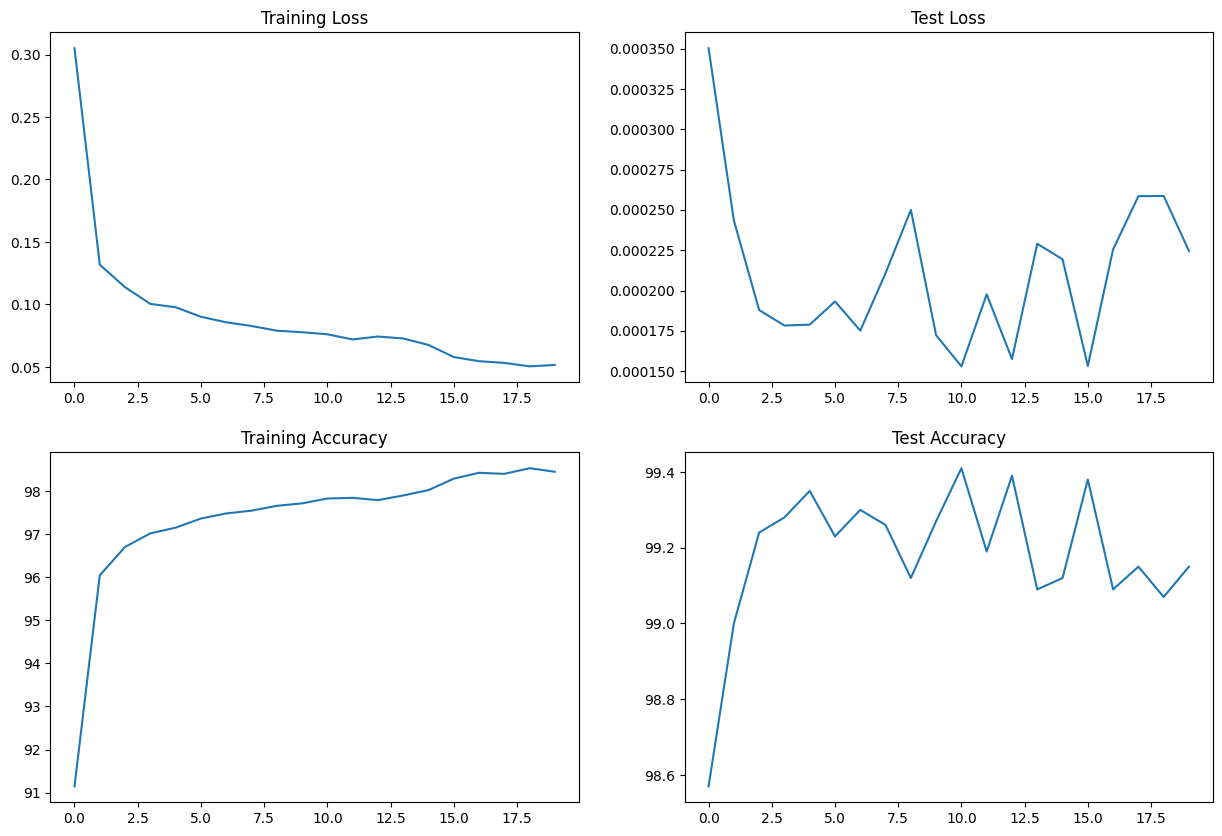

In [30]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [31]:
# Optional: View model summary
# !pip install torchsummary
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 26, 26]           2,320
       BatchNorm2d-4           [-1, 16, 26, 26]              32
         Dropout2d-5           [-1, 16, 26, 26]               0
            Conv2d-6           [-1, 32, 11, 11]           4,640
       BatchNorm2d-7           [-1, 32, 11, 11]              64
            Conv2d-8             [-1, 32, 9, 9]           9,248
       BatchNorm2d-9             [-1, 32, 9, 9]              64
        Dropout2d-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 32, 2, 2]           9,248
      BatchNorm2d-12             [-1, 32, 2, 2]              64
        Dropout2d-13             [-1, 32, 2, 2]               0
AdaptiveAvgPool2d-14             [-1, 3